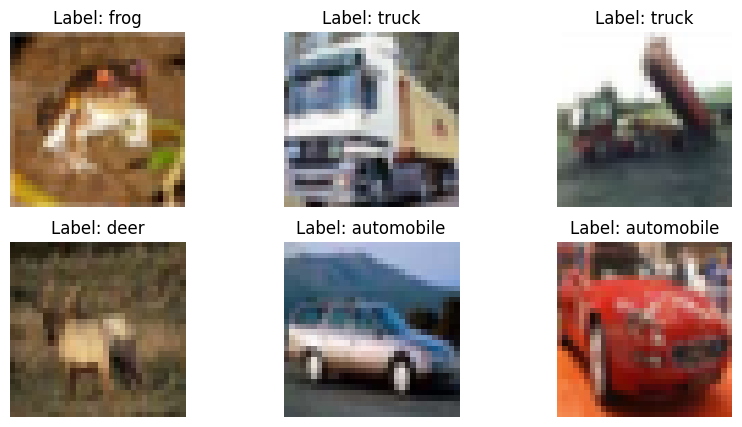

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.4323 - loss: 1.5785 - val_accuracy: 0.6468 - val_loss: 1.0120
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.5907 - loss: 1.1529 - val_accuracy: 0.6583 - val_loss: 0.9704
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6298 - loss: 1.0606 - val_accuracy: 0.6708 - val_loss: 0.9377
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6463 - loss: 1.0079 - val_accuracy: 0.6736 - val_loss: 0.9396
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.6636 - loss: 0.9634 - val_accuracy: 0.6639 - val_loss: 0.9580
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.6733 - loss: 0.9307 - val_accuracy: 0.6719 - val_loss: 0.9799
313/313 - 3s - 11ms/step - accuracy: 0.6708 - loss: 0.9377
Test accuracy: 67.08%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


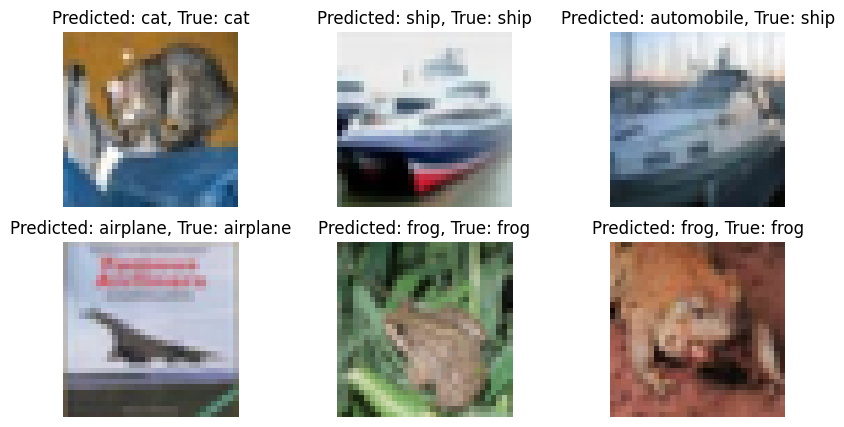

In [6]:
# 引入必要的庫
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping

# 1. 載入 CIFAR-10 數據集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 資料預處理：將圖像數據縮放到 [0, 1] 區間
x_train, x_test = x_train / 255.0, x_test / 255.0

# 顯示一些樣本圖像
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {class_names[y_train[i][0]]}")
    plt.axis('off')
plt.show()

# 2. 載入 VGG19 預訓練模型（不包括頂層分類器）
base_model = tf.keras.applications.VGG19(include_top=False, input_shape=(32, 32, 3))

# 3. 解凍更多的 VGG19 模型層進行微調
base_model.trainable = True
fine_tune_at = 15  # 設定從第 15 層開始微調

# 再次編譯模型，為微調層設置較小的學習率
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 4. 增加數據增強
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# 5. 使用 Functional API 定義模型
inputs = layers.Input(shape=(32, 32, 3))  # 定義輸入層
x = data_augmentation(inputs)  # 添加數據增強層
x = base_model(x)  # 添加 VGG19 模型
x = layers.GlobalAveragePooling2D()(x)  # 池化層
x = layers.Dense(128, activation='relu')(x)  # 隱藏層
outputs = layers.Dense(10, activation='softmax')(x)  # 輸出層

# 定義模型
model = models.Model(inputs, outputs)

# 6. 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 7. 使用 EarlyStopping 回調避免過擬合
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 8. 訓練模型
model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stopping])

# 9. 評估模型
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# 顯示正確率，以百分比顯示
print(f"Test accuracy: {test_acc * 100:.2f}%")

# 10. 預測測試集中的圖像
predictions = model.predict(x_test)

# 顯示一些測試圖像和預測結果
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_test[i])
    plt.title(f"Predicted: {class_names[predictions[i].argmax()]}, True: {class_names[y_test[i][0]]}")
    plt.axis('off')
plt.show()